In [1]:
import JSSP
import gym
import time
import numpy as np
import random

# Environment Initialization

In [15]:
env_name = "JSSP-v0"
env = gym.make(env_name, instance_path = "instance3.txt")
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Dict(0: Box(0, 9, (10,), int64), 1: Box(-2, 10, (10,), int64))
Action space: Box(-1, 10, (10,), int64)


/Users/boyanggu/RL-Research-2022-Summer/JSSP/envs/JSSP_env.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_ap

# Action Choosing

In [3]:
def get_legal_action(env):
    legal_actions = env.get_legal_actions()
    legal_action = []
    for job in range(len(legal_actions)):
        if len(legal_actions[job]) == 0:
            legal_action.append(-1)
        else:
            legal_job_actions = [machine for machine in legal_actions[job] if machine not in legal_action]
            legal_job_actions.append(-1)
            legal_action.append(np.random.choice(legal_job_actions))
    return np.array(legal_action)

In [4]:
def get_efficient_legal_action(env):
    legal_actions = env.get_legal_actions()
    legal_action = []
    for job in range(len(legal_actions)):
        if len(legal_actions[job]) == 0:
            legal_action.append(-1)
        else:
            legal_job_actions = [machine for machine in legal_actions[job] if machine not in legal_action]
            if len(legal_job_actions) == 0:
                legal_action.append(-1)
            else:
                legal_action.append(np.random.choice(legal_job_actions))
    return np.array(legal_action)


# Baselines

## 1. Random Sampling

In [5]:
state = env.reset()
episodes = 50
max_score = -100000
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        #env.render()
        action = get_legal_action(env)
        # if not (np.all(action == -1)):
        #     print('Episode:{} Action:{} Time:{}'.format(episode, action, env.time))
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Total_reward:{}'.format(episode, score))
    max_score = max(max_score, score)
print('From {} Episodes best policy has reward {}'.format(episodes, max_score))

Episode:1 Total_reward:-57
Episode:2 Total_reward:-59
Episode:3 Total_reward:-65
Episode:4 Total_reward:-68
Episode:5 Total_reward:-74
Episode:6 Total_reward:-67
Episode:7 Total_reward:-62
Episode:8 Total_reward:-50
Episode:9 Total_reward:-75
Episode:10 Total_reward:-65
Episode:11 Total_reward:-50
Episode:12 Total_reward:-77
Episode:13 Total_reward:-59


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  "Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator."
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:191: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  "Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting."
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: Future gym 

Episode:14 Total_reward:-68
Episode:15 Total_reward:-69
Episode:16 Total_reward:-49
Episode:17 Total_reward:-59
Episode:18 Total_reward:-60
Episode:19 Total_reward:-61
Episode:20 Total_reward:-76
Episode:21 Total_reward:-67
Episode:22 Total_reward:-61
Episode:23 Total_reward:-51
Episode:24 Total_reward:-50
Episode:25 Total_reward:-66
Episode:26 Total_reward:-71
Episode:27 Total_reward:-52
Episode:28 Total_reward:-59
Episode:29 Total_reward:-66
Episode:30 Total_reward:-60
Episode:31 Total_reward:-52
Episode:32 Total_reward:-60
Episode:33 Total_reward:-76
Episode:34 Total_reward:-68
Episode:35 Total_reward:-52
Episode:36 Total_reward:-62
Episode:37 Total_reward:-69
Episode:38 Total_reward:-61
Episode:39 Total_reward:-61
Episode:40 Total_reward:-77
Episode:41 Total_reward:-50
Episode:42 Total_reward:-76
Episode:43 Total_reward:-75
Episode:44 Total_reward:-49
Episode:45 Total_reward:-67
Episode:46 Total_reward:-67
Episode:47 Total_reward:-64
Episode:48 Total_reward:-65
Episode:49 Total_rew

In [6]:
state = env.reset()
episodes = 50
max_score = -100000
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        #env.render()
        action = get_efficient_legal_action(env)
        # if not (np.all(action == -1)):
        #     print('Episode:{} Action:{} Time:{}'.format(episode, action, env.time))
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Total_reward:{}'.format(episode, score))
    max_score = max(max_score, score)
print('From {} Episodes best policy has reward {}'.format(episodes, max_score))

Episode:1 Total_reward:-57
Episode:2 Total_reward:-67
Episode:3 Total_reward:-64
Episode:4 Total_reward:-67
Episode:5 Total_reward:-64
Episode:6 Total_reward:-64
Episode:7 Total_reward:-64
Episode:8 Total_reward:-64
Episode:9 Total_reward:-67
Episode:10 Total_reward:-64
Episode:11 Total_reward:-64
Episode:12 Total_reward:-57
Episode:13 Total_reward:-67
Episode:14 Total_reward:-59
Episode:15 Total_reward:-49
Episode:16 Total_reward:-57
Episode:17 Total_reward:-59
Episode:18 Total_reward:-67
Episode:19 Total_reward:-49
Episode:20 Total_reward:-64
Episode:21 Total_reward:-74
Episode:22 Total_reward:-74
Episode:23 Total_reward:-49
Episode:24 Total_reward:-59
Episode:25 Total_reward:-74
Episode:26 Total_reward:-59
Episode:27 Total_reward:-67
Episode:28 Total_reward:-74
Episode:29 Total_reward:-74
Episode:30 Total_reward:-49
Episode:31 Total_reward:-57
Episode:32 Total_reward:-49
Episode:33 Total_reward:-74
Episode:34 Total_reward:-67
Episode:35 Total_reward:-57
Episode:36 Total_reward:-67
E

## 2. Q-Learning

In [7]:
def update(Q, s_key, s_next_key, a_key, r, eta, gma):

    if s_key not in Q.keys():
        Q[s_key] = {}

    if s_next_key not in Q.keys() or Q[s_next_key] == {}:
        max_next_s_Q = 0
    else:
        max_next_s_Q = max(Q[s_next_key].values())

    if a_key not in Q[s_key].keys():
        Q[s_key][a_key] = 0
    Q[s_key][a_key] = Q[s_key][a_key] + eta * (r + gma * max_next_s_Q - Q[s_key][a_key])

    return Q

In [17]:
# 1. Load Environment and Q-table structure
env_name = "JSSP-v0"
env = gym.make(env_name, instance_path = "instance3.txt")
Q = {}
# 2. Parameters of Q-learning
eta = .628
gamma = .9
epis = 500
epsilon = .1
rev_list = [] # rewards per episode calculate
# 3. Q-learning Algorithm
for i in range(epis):
    # Reset environment
    s = env.reset()
    rAll = 0
    d = False
    # The Q-Table learning algorithm
    while not d:
        # env.render()
        # Choose action from Q table
        s_key = tuple(np.concatenate((s[1], s[0])))
        if s_key not in Q.keys() or Q[s_key] == {} or random.uniform(0, 1) < epsilon:
            a = get_legal_action(env)
        else:
            a = max(Q[s_key], key = Q[s_key].get)
        #Get new state & reward from environment
        s_next, r, d, _ = env.step(a)
        #Update Q-Table with new knowledge
        s_next_key = tuple(np.concatenate((s_next[1], s_next[0])))
        a_key = tuple(a)
        Q = update(Q, s_key, s_next_key, a_key, r, eta, gamma)
        rAll += r
        s = s_next
    rev_list.append(rAll)
    print("Episode: " + str(i) + " has reward " + str(rAll))
    # env.render()
# Code will stop at d == True, and render one state before it
print("Reward Sum on all episodes " + str(sum(rev_list)/epis))
print("Final Values Q-Table")
print(Q)

/Users/boyanggu/RL-Research-2022-Summer/JSSP/envs/JSSP_env.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_ap

Episode: 0 has reward -1297
Episode: 1 has reward -1327
Episode: 2 has reward -1311
Episode: 3 has reward -1164
Episode: 4 has reward -1303
Episode: 5 has reward -1214
Episode: 6 has reward -1196
Episode: 7 has reward -1202
Episode: 8 has reward -1237
Episode: 9 has reward -1317
Episode: 10 has reward -1217
Episode: 11 has reward -1348
Episode: 12 has reward -1239
Episode: 13 has reward -1308
Episode: 14 has reward -1364
Episode: 15 has reward -1436
Episode: 16 has reward -1386
Episode: 17 has reward -1336
Episode: 18 has reward -1338
Episode: 19 has reward -1426
Episode: 20 has reward -1259
Episode: 21 has reward -1267
Episode: 22 has reward -1222
Episode: 23 has reward -1246
Episode: 24 has reward -1488
Episode: 25 has reward -1336
Episode: 26 has reward -1215
Episode: 27 has reward -1233
Episode: 28 has reward -1260
Episode: 29 has reward -1166
Episode: 30 has reward -1318
Episode: 31 has reward -1299
Episode: 32 has reward -1210
Episode: 33 has reward -1204
Episode: 34 has reward -

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<function matplotlib.pyplot.show(close=None, block=None)>

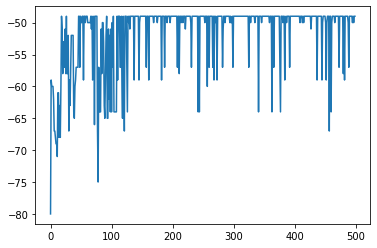

In [14]:
import matplotlib.pyplot as plt
plt.plot(rev_list)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

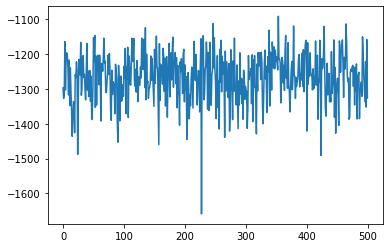

In [18]:
plt.plot(rev_list)
plt.show

In [ ]:
state = env.reset()
episodes = 50
max_score = -100000
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        #env.render()
        action = get_legal_action(env)
        # if not (np.all(action == -1)):
        #     print('Episode:{} Action:{} Time:{}'.format(episode, action, env.time))
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Total_reward:{}'.format(episode, score))
    max_score = max(max_score, score)
print('From {} Episodes best policy has reward {}'.format(episodes, max_score))

## 2. Q-Learning

In [ ]:
# 1. Load Environment and Q-table structure
env_name = "JSSP-v0"
env = gym.make(env_name, instance_path = "instance1.txt")
Q = {}
# 2. Parameters of Q-learning
eta = .628
gma = .9
epis = 50
rev_list = [] # rewards per episode calculate
# 3. Q-learning Algorithm
for i in range(epis):
    # Reset environment
    s = env.reset()
    rAll = 0
    d = False
    # The Q-Table learning algorithm
    while not d:
        # env.render()
        # Choose action from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state & reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + eta*(r + gma*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
    rev_list.append(rAll)
    print("Episode: " + str(i) + " has reward " + str(rAll))
    # env.render()
# Code will stop at d == True, and render one state before it
print("Reward Sum on all episodes " + str(sum(rev_list)/epis))
print("Final Values Q-Table")
print(Q)

# Baselines

## 1. Random Sampling

In [ ]:
state = env.reset()
episodes = 50
max_score = -100000
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        #env.render()
        action = get_legal_action(env)
        # if not (np.all(action == -1)):
        #     print('Episode:{} Action:{} Time:{}'.format(episode, action, env.time))
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Total_reward:{}'.format(episode, score))
    max_score = max(max_score, score)
print('From {} Episodes best policy has reward {}'.format(episodes, max_score))

## 2. Q-Learning

In [ ]:
# 1. Load Environment and Q-table structure
env_name = "JSSP-v0"
env = gym.make(env_name, instance_path = "instance1.txt")
Q = {}
# 2. Parameters of Q-learning
eta = .628
gma = .9
epis = 50
rev_list = [] # rewards per episode calculate
# 3. Q-learning Algorithm
for i in range(epis):
    # Reset environment
    s = env.reset()
    rAll = 0
    d = False
    # The Q-Table learning algorithm
    while not d:
        # env.render()
        # Choose action from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state & reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + eta*(r + gma*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
    rev_list.append(rAll)
    print("Episode: " + str(i) + " has reward " + str(rAll))
    # env.render()
# Code will stop at d == True, and render one state before it
print("Reward Sum on all episodes " + str(sum(rev_list)/epis))
print("Final Values Q-Table")
print(Q)